# HW4 Levenberg-Marquardt Algorithm

Original jupyter notebook is uploaded at [GitHub](https://github.com/zhuo34/csmath2022).

[4.15649902e-10 4.15649902e-10] 48
[4.15649902e-10 4.15649902e-10]


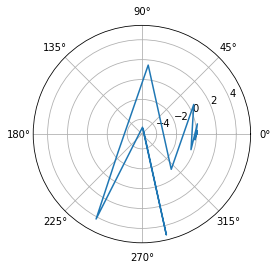

In [268]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve


def gd(gf, x0, alpha=0.01, max_step=1000, epsilon=1e-9):
    x = x0
    step = 0
    while step < max_step:
        g = gf(x) # [n, 1]
        if np.max(np.abs(g)) < epsilon:
            break
        x = x - alpha * g
        step += 1
    return x


def lm(f, gf, Gf, x0, tau=1e-3, max_step=1000, epsilon=1e-9, output_all=False):
    x = x0
    step = 0
    n = len(x)
    I = np.eye(n)
    outputs = {"x": [], "g": [], "G": [], "s": [], "r": [], "u": []}
    while step < max_step:
        g = gf(x) # [n, 1]
        G = Gf(x) # [n, n]
        if step == 0:
            u = tau * np.max(np.diag(G))

        if np.max(np.abs(g)) < epsilon:
            break

        while not np.all(np.linalg.eigvals(G + u * I) > 0):
            # print("change u", u)
            u *= 4
        old_u = u
        s = lu_solve(lu_factor(G + u * I), -g) # [n, ]
        if np.max(np.abs(s)) < epsilon:
            break
        # s = -np.linalg.inv(G + u * I) @ g
        x_new = x + s
        df = f(x) - f(x_new)
        dq = -g.T @ s - 0.5 * s.T @ G @ s
        r = df / dq
        if r < 0.25:
            u *= 4
        elif r > 0.75:
            u /= 2
        if r > 0:
            x = x_new

        step += 1
        outputs["x"].append(x)
        outputs["g"].append(g.T)
        outputs["G"].append(G)
        outputs["s"].append(s)
        outputs["r"].append(r)
        outputs["u"].append(old_u)
    if not output_all:
        return x
    outputs["step"] = step
    outputs["x"] = np.array(outputs["x"])
    outputs["g"] = np.array(outputs["g"])
    outputs["G"] = np.array(outputs["G"])
    outputs["s"] = np.array(outputs["s"])
    outputs["r"] = np.array(outputs["r"])
    outputs["u"] = np.array(outputs["u"])
    return x, outputs

f = lambda x: x[0] ** 2 + x[1] ** 2
gf = lambda x: 2 * x.T
Gf = lambda x: np.eye(2)

x0 = np.array([5, 5])
x, outputs = lm(f, gf, Gf, x0, output_all=True)

print(x, outputs["step"])
print(outputs["x"][-1])
ax = plt.subplot(projection="polar")
ax.set_rmax(5)
ax.set_rmin(0)
# plt.polar(np.sqrt(np.sum(outputs["x"] ** 2, axis=1)))
ax.plot(outputs["x"][:, 0], outputs["x"][:, 1])
plt.show()


In [270]:
def least_squre_LM(f, J, X, Y, p0, tau=1e-6, max_step=1000, epsilon=1e-9, output_all=False):
    F = lambda p: 0.5 * (f(X, p) - Y) @ (f(X, p) - Y).T
    gF = lambda p: J(X, p).T @ (f(X, p) - Y).T
    GF = lambda p: J(X, p).T @ J(X, p)
    return lm(F, gF, GF, p0, tau=tau, max_step=max_step, epsilon=epsilon, output_all=output_all)

# f: exp(a*x^2 + b*x + c)
np.random.seed(0)
p = np.array([1, 2, 3])
f = lambda x, p: np.exp(p[0] * (x**2) + p[1] * x + p[2])
M = 100
X = np.linspace(0, 1, M)
Y = [f(x, p) + np.random.normal(0, 1) for x in X]

def J(X, p):
    m, n = len(X), len(p)
    J = np.zeros([m, n])
    f_value = np.exp(p[0] * (X**2) + p[1] * X + p[2])
    J[:, 0] = (X ** 2) * f_value
    J[:, 1] = X * f_value
    J[:, 2] = 1 * f_value
    # print("Jf", J)
    return J

p0 = np.array([1, 1, 1])
p1 = least_squre_LM(f, J, X, Y, p0, max_step=200)
print(p1)

[1.04313737 1.94480705 3.01523501]
